# import all modules

In [1]:
%matplotlib inline
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
from six.moves import range

import PIL.Image as Image
import PIL.ImageChops as ImageChops
import PIL.ImageFilter as ImageFilter
import PIL.ImageEnhance as ImageEnhance
import os
import sys
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from collections import OrderedDict
import pandas as pd
import matplotlib 

# load gray scale data from pickle file


In [2]:

pickle_file = 'SVHN_multin.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset_t = save['train_dataset']
  train_labels_t = save['train_labels']
  valid_dataset_t = save['valid_dataset']
  valid_labels_t = save['valid_labels']
  test_dataset_t = save['test_dataset']
  test_labels_t = save['test_labels']
  del save  
  print('Training set', train_dataset_t.shape, train_labels_t.shape)
  print('Validation set', valid_dataset_t.shape, valid_labels_t.shape)
  print('Test set', test_dataset_t.shape, test_labels_t.shape)

Training set (230070, 32, 32, 1) (230070, 6)
Validation set (5684, 32, 32, 1) (5684, 6)
Test set (13068, 32, 32, 1) (13068, 6)


# Define accuracy function
How many digits did we  right?

In [3]:
#how much house numbers are correct -> alle digits of a house number must be correct
def accuracy(predictions, labels,show_details=False,n=100):
 
  if show_details:
        for i in range(0,n):
            print(labels[i],'  ',predictions[i],'  ',np.all(labels[i] == predictions[i]))
  return (100.0 * np.sum(np.all(predictions == labels,axis=1)))/ predictions.shape[0]




#define character level accuracy measuere

def accuracyCharLevel(predictions, labels):

  return (100.0 * np.sum(predictions == labels) / predictions.shape[1] / predictions.shape[0])

print("Success")

Success


## Function to display random images with labels

In [4]:
def display_images(images, labels, rand_indices=None):
    """
        Display random images from a set and return indices so we can match the results
    """
    display_size = 10
    display_per_row = 10
    num_rows = display_size/display_per_row
    if rand_indices is None:
        rand_indices = np.random.randint(0, images.shape[0], size=display_size)
    row_size = 20
    col_size = 20

    fig = plt.figure(figsize=(20, 20))
    for idx in range(len(rand_indices)):
        orig_idx = rand_indices[idx]
        display_row_idx = int(idx/display_per_row) + 1
        display_col_idx = idx%display_per_row +1
        a=fig.add_subplot(display_row_idx, display_per_row, display_col_idx, frameon=False)
        a.get_yaxis().set_visible(False)
        a.get_xaxis().set_visible(False)
        a.imshow(images[orig_idx,:,:,0], cmap="Greys_r")
        
        house_num = ''
        for k in np.arange(labels[orig_idx,0]):
            house_num += str(labels[orig_idx,k+1])
      
        a.set_title(house_num)
    return rand_indices

## Show some preprocessed images from training and test data sets with labels

array([  681,  6537, 12454,  3084,  5047,   167,  1382,  3298, 12936,  4279])

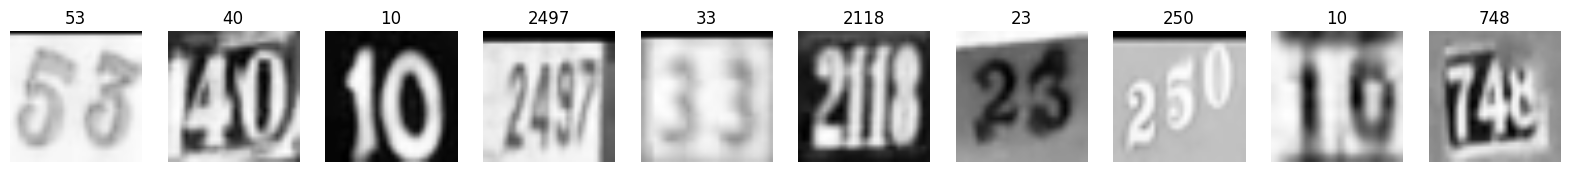

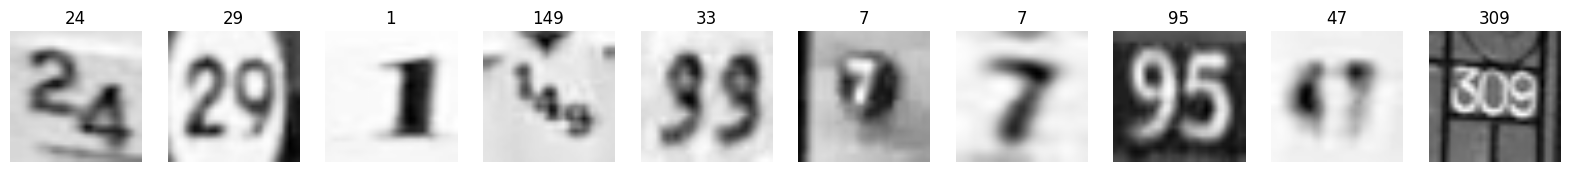

In [5]:
display_images(train_dataset_t, train_labels_t)
display_images(test_dataset_t, test_labels_t)

# Data augmentation
## Helper functions to convert images from numpy to PIL and back

In [7]:
def array2image(fa):
   
    return Image.frombytes("F", (fa.shape[1], fa.shape[0]), fa.tostring())
   

def image2Array(img):    
    ar=np.array(img)*1.0
    return ar

[[-0.71279907 -0.90850067 -0.20739746 ..., -0.22570038 -0.51390076
  -0.04090118]
 [-0.31069946 -0.60939789 -0.20709991 ..., -0.22619629 -0.5141983
  -0.92710114]
 [-0.31060028 -0.13639832 -0.62000275 ..., -0.33940125 -0.5141983
  -0.62850189]
 ..., 
 [-0.53890228 -0.83779907 -0.23950195 ..., -0.40570068 -0.13459778
  -0.73220062]
 [-0.13680267 -0.13659668 -0.31030273 ..., -0.36139679 -0.02010345
  -0.20500183]
 [-0.13690186 -0.73459625 -0.79460144 ..., -0.36129761 -0.79180145
  -0.97669983]]


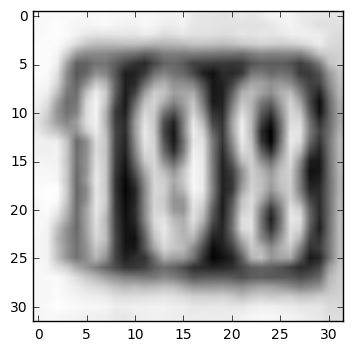

In [8]:
#some test
idx=0
npim=train_dataset_t[idx,:,:,0]

im=array2image(npim).convert("L")
plt.imshow(im,cmap="Greys_r")


npimg=image2Array(im)
print(npimg-npim)

## Augment one image

In [9]:
from time import time
def generateAugmentedData(npimg,label,images,labels,n=1):
  
    #first append original image
    images.append(npimg)
    labels.append(label)
    im=array2image(npimg).convert("L")
    # do n random rotations 
    for i in range(0,n):
        rot=np.random.uniform(-20,20)
        img=im.rotate(rot,Image.BILINEAR)
        images.append(image2Array(img))
        labels.append(label)
    #do n random movements    
    for i in range(0,n):
        dx=np.random.randint(-5,5)
        dy=np.random.randint(-5,5)
        img=ImageChops.offset(im,dx,dy)
        images.append(image2Array(img))
        labels.append(label)
    #do n random sharpness operations
    enhancer = ImageEnhance.Sharpness(im)
    for i in range(0,n):
        en=np.random.uniform(-2,3)
        img=enhancer.enhance(en)
        images.append(image2Array(img))
        labels.append(label)
    
   #do n random brightness operations
    enhancer = ImageEnhance.Brightness(im)
    for i in range(0,n):
        en=np.random.uniform(0.01,2)
        img=enhancer.enhance(en)
        images.append(image2Array(img))
        labels.append(label)
    #do n random contrast operations
    enhancer = ImageEnhance.Contrast(im)
    for i in range(0,n):
        en=np.random.uniform(0.01,3)
        img=enhancer.enhance(en)
        images.append(image2Array(img))
        labels.append(label)

 
    return images,labels
    


230070
75.7368
2.98023223877e-06
75.7368
time used s 0.536942958832
6000
106.657241228


xrange(10)

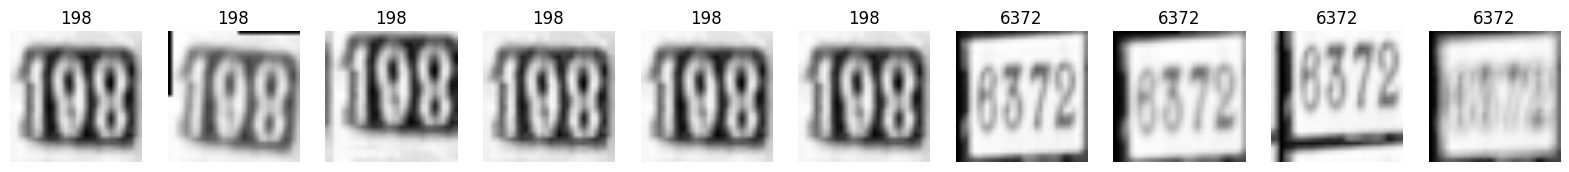

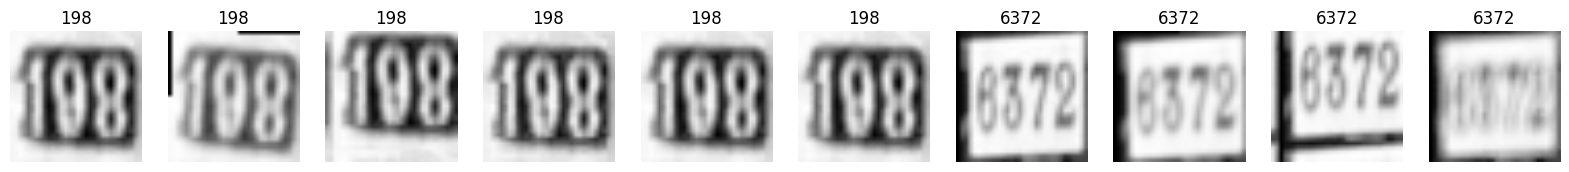

In [10]:
#some tests
idx=0
print (len(train_dataset_t))
npim=train_dataset_t[idx,:,:,0]
print(np.mean(npim))
mean=np.mean(npim)
imn=train_dataset_t[idx]-mean
print(np.sum(imn)/1024.0)
print(np.mean(train_dataset_t[idx]))
t0=time()
images=[]
labels=[]
for idx in range(0,1000):
    npim=train_dataset_t[idx,:,:,0]
    images,labels=generateAugmentedData(npim, train_labels_t[idx],images,labels) 

dataset = np.ndarray([len(images),32,32,1], dtype='float32')
for idx in range(0,len(images)):
    image=images[idx]
  #  print(image[:,:,np.newaxis].shape)
  #  im=image[:,:,np.newaxis]
  
    dataset[idx,:,:,:] = image[:,:,np.newaxis]
print ("time used s",time()-t0)    
print(len(dataset))
ind=range(0,10)
display_images(dataset, np.array(labels),ind)   

sum=0.0
for idx in range(0,len(images)):
    image= dataset[idx,:,:,:]
    sum+=np.sum(image)/1024.0
print (sum/len(images))    
mean=np.mean(dataset)
std=np.std(dataset)
display_images((dataset-mean)/std, np.array(labels),ind)   

In [12]:
def generateAugmentedDataSet(image_data,image_label,n=2):
    init=True
    labels=[]
    len_data=len(image_data)
   
    for idx in range(0,len_data):    
        if idx%20000==0:
            print(idx)
        npim=image_data[idx,:,:,0]
        images=[]
      
        images,labels=generateAugmentedData(npim, image_label[idx],images,labels,n) 
        lenIm=len(images)
       
        if init==True:
            print(lenIm)
            img_dataset = np.ndarray([lenIm*len_data,32,32,1], dtype='float32')
            init=False
        for i in range(0,lenIm):
            image=images[i]
            img_dataset[idx*lenIm+i,:,:,:] = image[:,:,np.newaxis]
    img_lables=np.array(labels)   
    del labels
    return img_dataset, img_lables 

0
16
20000
40000
60000
80000
100000
120000
140000
160000
180000
200000
220000
0
6
0
6
230070 3681120
5684 34104
13068 78408


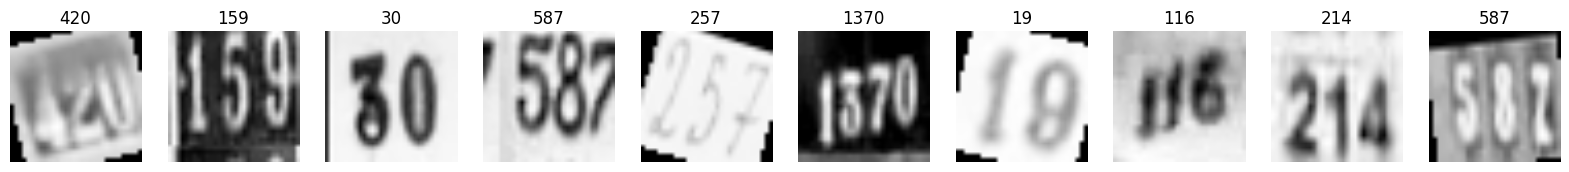

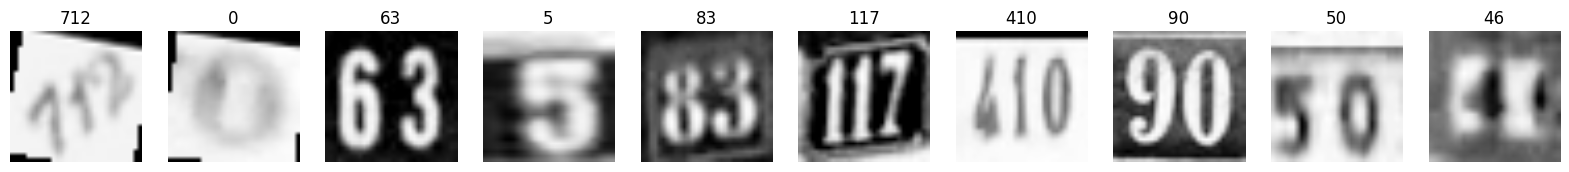

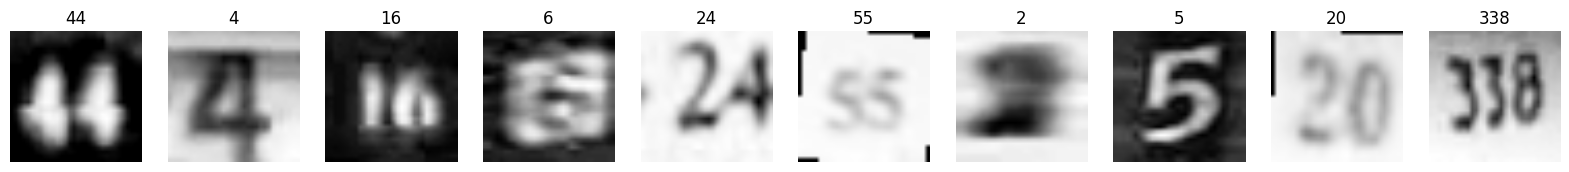

In [13]:
train_dataset_augm,train_labels_augm=generateAugmentedDataSet(train_dataset_t, train_labels_t,3)   

display_images(train_dataset_augm, train_labels_augm)   
valid_dataset_augm, valid_labels_augm=generateAugmentedDataSet(valid_dataset_t, valid_labels_t,1) 
display_images(valid_dataset_augm, valid_labels_augm)  

test_dataset_augm, test_labels_augm=generateAugmentedDataSet(test_dataset_t, test_labels_t,1) 
display_images(test_dataset_augm, test_labels_augm)  

print(len(train_dataset_t),len(train_dataset_augm))
print(len(valid_dataset_t),len(valid_dataset_augm))
print(len(test_dataset_t),len(test_dataset_augm))


## Shuffle data sets

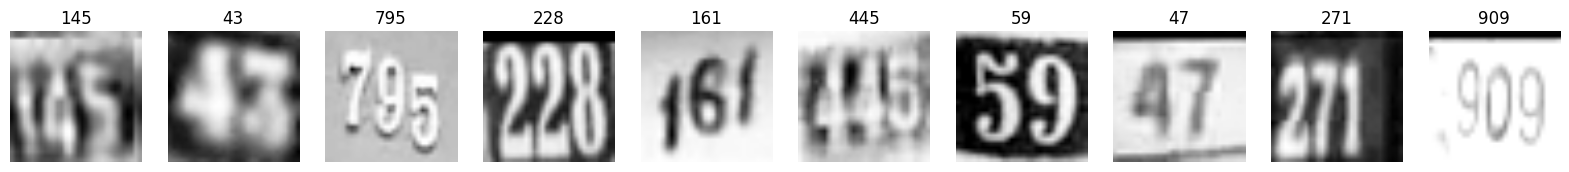

In [18]:

train_dataset = train_dataset_t
train_labels = train_labels_t
valid_dataset = valid_dataset_t
valid_labels = valid_labels_t
test_dataset = test_dataset_t
test_labels = test_labels_t

train_dataset = train_dataset_augm
train_labels = train_labels_augm
#valid_dataset = valid_dataset_augm
#valid_labels = valid_labels_augm
#test_dataset = test_dataset_augm
#test_labels = test_labels_augm

train_dataset,train_labels=shuffle(train_dataset,train_labels)
display_images(train_dataset, train_labels) 

valid_dataset, valid_labels=shuffle(valid_dataset, valid_labels)
display_images(valid_dataset, valid_labels) 

test_dataset, test_labels=shuffle(test_dataset, test_labels)
display_images(test_dataset, test_labels) 

## normalize the images by mean and standard deviation per image


In [16]:
def normalizeImages(dataset):
    for idx in range (0,len(dataset)):
        im= dataset[idx,:,:,0]
        mean=np.mean(im, dtype=np.float64)
        std=np.std(im, dtype=np.float64)
        if std<0.001:
            std=1.0
        im=(im-mean)/std
        dataset[idx,:,:,0]=im



In [17]:
normalizeImages(train_dataset)
normalizeImages(valid_dataset)
normalizeImages(test_dataset)
print (train_dataset.shape)
print (valid_dataset.shape)
print (test_dataset.shape)
print("normalization done")

(3681120, 32, 32, 1)
(5684, 32, 32, 1)
(13068, 32, 32, 1)
normalization done


## plot accuracy and loss

In [19]:
def plot_results(acc_train,acc_valid,losses,ymin=80,ymax=100):
    matplotlib.rc('xtick', labelsize=14) 
    matplotlib.rc('ytick', labelsize=14) 
    matplotlib.rcParams.update({'font.size': 18})
    steps=losses.keys()
    loss=losses.values()
   
    dflosses=pd.DataFrame(losses.values(),columns=['Loss'],index=steps)
    dflosses.index.names=['Steps']
    dflosses.plot(figsize=(15,10),ylim=(0.0,2.0),title="Loss")
    dfacc=pd.DataFrame([acc_train.values(),acc_valid.values()])

    dfacc=dfacc.transpose()
    dfacc.columns=['Train Accurary','Validation Accurary']
    dfacc.index=steps
    dfacc.index.names=['Steps']
    dfacc.plot(figsize=(15,10),ylim=(ymin,ymax),title="Accuracy")

# Convolution Network

## Helper functions

In [20]:
# Helper functions
def create_weight_conv(name,shape):
    return tf.get_variable(name, shape,initializer=tf.contrib.layers.xavier_initializer_conv2d())

def create_weight(name,shape):
    return tf.get_variable(name, shape,initializer=tf.contrib.layers.xavier_initializer())

def create_bias(name,shape):
    return tf.Variable(tf.constant(1.0, shape=shape),name=name)


def create_conv_layer(name,data, weights,padding,conv_stride):
    return tf.nn.conv2d(data, weights, [1, conv_stride, conv_stride, 1], padding)

def create_pool_layer(name,data,pool_window_size,padding,pool_stride):
    return tf.nn.max_pool(data, pool_window_size, pool_stride, padding)

def get_conv_shape(data_shape, weights_shape,padding,conv_stride):
    if padding == 'VALID':
        new_height = int(np.ceil((1.0*(data_shape[1] - weights_shape[0] + 1)) / conv_stride))
        new_width = int(np.ceil((1.0*(data_shape[2] - weights_shape[1] + 1)) / conv_stride))
    else:
        new_height = int(np.ceil(1.0*data_shape[1]) / conv_stride)
        new_width = int(np.ceil(1.0*data_shape[2] / conv_stride))
    return (data_shape[0], new_height, new_width, weights_shape[3])

def get_pool_shape(data_shape,pool_stride):
    new_height = int(np.ceil(1.0*data_shape[1] / pool_stride[1]))
    new_width = int(np.ceil(1.0*data_shape[2] / pool_stride[2]))
    return (data_shape[0], new_height, new_width, data_shape[3])


## Try a  CNN with several  convolution layers 
Conv 5x5 ->Conv 5x5->MaxPool-->Conv3 x3->conv 3x3->maxpool->conv3x3->fully connected->logits

In [21]:
def deepCNN2(datasets,topology_params, learning_params,model_name,num_channels=1):
    """Construct Model"""
    print ("deep CNN")
    image_size = 32 
    num_labels = 11 # 0-9, + blank 
    
    conv_stride = 1
    pool_window_size = [1, 2, 2, 1]
    pool_stride = [1, 2, 2, 1]
    padconv = 'SAME'
    padpool = 'SAME'
    train_dataset = datasets['train_dataset']
    train_labels = datasets['train_labels']
    valid_dataset = datasets['valid_dataset']
    valid_labels = datasets['valid_labels']
    test_dataset = datasets['test_dataset']
    test_labels = datasets['test_labels']
    

    depth1 = topology_params['depth1']
    depth2 = topology_params['depth2']
    depth3 = topology_params['depth3']
    depth4 = topology_params['depth4']
    depth5 = topology_params['depth5']
    patch_size1=topology_params['patch_size1']
    patch_size2=topology_params['patch_size2']

 
    num_hidden1 = topology_params['num_hidden1']
        
    num_steps=learning_params['num_steps']
    batch_size=learning_params['batch_size']
    learn_rate=learning_params['learning_rate']
    
    shape = [batch_size, image_size, image_size, num_channels]

    graph = tf.Graph()
    losses=OrderedDict()
    acc_train=OrderedDict()
    acc_valid=OrderedDict()
  
    
    with  graph.as_default():
      #define weights and biases
      # Input data.
      tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size, image_size, num_channels))
      tf_train_labels = tf.placeholder(tf.int32, shape=(batch_size, 6))
      tf_valid_dataset =  tf.placeholder(tf.float32, shape=(batch_size, image_size, image_size, num_channels))
      tf_valid_labels = tf.placeholder(tf.int32, shape=(batch_size, 6))
      tf_test_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size, image_size, num_channels))
      tf_test_labels = tf.placeholder(tf.int32, shape=(batch_size, 6))

      # Convolution layers.
      # First convolution layer
      conv_1_weights = create_weight_conv("W1",shape=[patch_size1, patch_size1, num_channels, depth1])
      conv_1_biases = create_bias('B1',shape=[depth1])     
      conv_1_shape = get_conv_shape(tf_train_dataset.get_shape().as_list(),conv_1_weights.get_shape().as_list(),\
                                    padconv,conv_stride)    
    
      print("cv1",conv_1_shape)
  
      # Second convolution layer 
      conv_2_weights = create_weight_conv("W2",shape=[patch_size1, patch_size1, depth1, depth2])
      conv_2_biases = create_bias('B2',shape=[depth2])
      conv_2_shape = get_conv_shape(conv_1_shape, conv_2_weights.get_shape().as_list(),padconv,conv_stride)
      pool_2_shape = get_pool_shape(conv_2_shape,pool_stride)
    
      print("cv2",conv_2_shape)
      print("p2",pool_2_shape)
    
    
      # Third convolution layer
      conv_3_weights = create_weight_conv("W3",shape=[patch_size2, patch_size2, depth2, depth3])
      conv_3_biases = create_bias('B3',shape=[depth3])     
      conv_3_shape = get_conv_shape(pool_2_shape,conv_3_weights.get_shape().as_list(),\
                                    padconv,conv_stride)    
    
      print("cv3",conv_3_shape)
  
      # Fourth convolution layer 
      conv_4_weights = create_weight_conv("W4",shape=[patch_size2, patch_size2, depth3, depth4])
      conv_4_biases = create_bias('B4',shape=[depth4])
      conv_4_shape = get_conv_shape(conv_3_shape, conv_4_weights.get_shape().as_list(),padconv,conv_stride)
      pool_4_shape = get_pool_shape(conv_4_shape,pool_stride)
    
      print("cv4",conv_4_shape)
      print("p4",pool_4_shape)
    
     # Third convolution layer 
      conv_5_weights = create_weight_conv("W5",shape=[patch_size2, patch_size2, depth4, num_hidden1])
      conv_5_biases = create_bias('B5',shape=[num_hidden1])
      conv_5_shape = get_conv_shape(pool_4_shape, conv_5_weights.get_shape().as_list(),padconv,conv_stride)
        
      print("cv5",conv_5_shape)
    
      #fully connected layer
      final_shape=conv_5_shape
      final_flat = final_shape[1] * final_shape[2] * final_shape[3]
      print("ff",final_flat)
      weights_full = create_weight("FW",(final_flat, num_hidden1))
      biases_full = create_bias("FB",(num_hidden1,))
  
        
      # Hidden layer
      s0_w = create_weight("WHS0",(num_hidden1, num_labels))
      s1_w = create_weight("WHS1",(num_hidden1, num_labels))
      s2_w = create_weight("WHS2",(num_hidden1, num_labels))
      s3_w = create_weight("WHS3",(num_hidden1, num_labels))
      s4_w = create_weight("WHS4",(num_hidden1, num_labels))
      s0_b = create_bias("BHS0",(num_labels,))
      s1_b = create_bias("BHS1",(num_labels,))
      s2_b = create_bias("BHS2",(num_labels,))
      s3_b = create_bias("BHS3",(num_labels,))
      s4_b = create_bias("BHS4",(num_labels,))   
    

      # CNN model
      def model(data, keep_prob):
        conv1 = tf.nn.relu(create_conv_layer('C1',data, conv_1_weights,padconv,conv_stride) + conv_1_biases)
        lrn1 = tf.nn.local_response_normalization(conv1)
      
        
        conv2 = tf.nn.relu(create_conv_layer('C2',lrn1, conv_2_weights,padconv,conv_stride) + conv_2_biases)
        lrn2 = tf.nn.local_response_normalization(conv2)
        pool2 = create_pool_layer('P2',lrn2,pool_window_size,padpool,pool_stride)
        
        
        conv3 = tf.nn.relu(create_conv_layer('C3',pool2, conv_3_weights,padconv,conv_stride) + conv_3_biases)
        lrn3 = tf.nn.local_response_normalization(conv3)
      
        
        conv4 = tf.nn.relu(create_conv_layer('C4',lrn3, conv_4_weights,padconv,conv_stride) + conv_4_biases)
        lrn4 = tf.nn.local_response_normalization(conv4)
        pool4 = create_pool_layer('P4',lrn4,pool_window_size,padpool,pool_stride)
        
        
        conv5 =create_conv_layer('C5',pool4, conv_5_weights,padconv,conv_stride) 
   
     
       
        last=conv5
      
        shape = last.get_shape().as_list() 
     #   print (shape)
        reshape = tf.reshape(last, [shape[0], final_flat])
        # First fully connected layer
        full = tf.nn.relu(tf.matmul(reshape, weights_full) + biases_full)
        final = tf.nn.dropout(full, keep_prob)
        
        #logits
        logits0 = tf.matmul(final, s0_w) + s0_b  #lenght of house number
        logits1 = tf.matmul(final, s1_w) + s1_b  #1. digit
        logits2 = tf.matmul(final, s2_w) + s2_b  #2. digit
        logits3 = tf.matmul(final, s3_w) + s3_b  #3. digit
        logits4 = tf.matmul(final, s4_w) + s4_b  #4. digit
        return [logits0, logits1, logits2, logits3, logits4]

      # Training computation.
      [logits0, logits1, logits2, logits3, logits4] = model(tf_train_dataset, 0.5)
      # Define loss function.
      loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits0, tf_train_labels[:,0])) +\
    tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits1, tf_train_labels[:,1])) +\
    tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits2, tf_train_labels[:,2])) +\
    tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits3, tf_train_labels[:,3])) +\
    tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits4, tf_train_labels[:,4]))

      # Optimizer.
      global_step = tf.Variable(0)
      #learning rate with exponential decay.
    #  learning_rate = tf.train.exponential_decay(learn_rate, global_step, 20000, 0.95) 
   #   optimizer = tf.train.AdagradOptimizer(learning_rate).minimize(loss, global_step=global_step)
   #   optimizer = tf.train.AdadeltaOptimizer(learning_rate).minimize(loss, global_step=global_step)
      # Predictions for the training, validation, and test data.
      optimizer = tf.train.AdamOptimizer(learn_rate).minimize(loss)
    
      [logits0, logits1, logits2, logits3, logits4] = model(tf_train_dataset, 1.0)
      train_prediction = tf.pack([tf.nn.softmax(logits0),\
                                 tf.nn.softmax(logits1),\
                                 tf.nn.softmax(logits2),\
                                 tf.nn.softmax(logits3),\
                                 tf.nn.softmax(logits4)])
    
      [logits0, logits1, logits2, logits3, logits4] = model(tf_valid_dataset, 1.0)
        
      valid_prediction = tf.pack([tf.nn.softmax(logits0),\
                                 tf.nn.softmax(logits1),\
                                 tf.nn.softmax(logits2),\
                                 tf.nn.softmax(logits3),\
                                 tf.nn.softmax(logits4)])   
    
      [logits0, logits1, logits2, logits3, logits4] = model(tf_test_dataset, 1.0)   
        
      test_prediction = tf.pack([tf.nn.softmax(logits0),\
                                 tf.nn.softmax(logits1),\
                                 tf.nn.softmax(logits2),\
                                 tf.nn.softmax(logits3),\
                                 tf.nn.softmax(logits4)])   
     

      saver = tf.train.Saver()



    with tf.Session(graph=graph) as session:
      tf.initialize_all_variables().run()  

      #"to be used after first iteration"
      #saver.restore(session, model_name)
      #print("Model restored.") 

      print('Initialized')
      for step in range(num_steps):
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
        batch_labels = train_labels[offset:(offset + batch_size),:]
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run(
          [optimizer, loss, train_prediction], feed_dict=feed_dict)

       
        if (step % 2500 == 0): 
          
            trainacc= accuracy(np.argmax(predictions, 2).T, batch_labels[:,0:5])
            acc_train[step]=trainacc   
            val_preds_total = np.ndarray((valid_labels.shape[0],valid_labels.shape[1]-1))
            for k in range(int(np.floor(valid_labels.shape[0] / batch_size))):
                batch_start_val = batch_size * k
                batch_end_val = batch_start_val + batch_size
                batch_D_val = valid_dataset[batch_start_val:batch_end_val,:,:,:]
                batch_L_val = valid_labels[batch_start_val:batch_end_val,:] 
                feed_dict = {tf_valid_dataset: batch_D_val, tf_valid_labels: batch_L_val}
                val_preds_total[batch_start_val:batch_end_val,:] = np.argmax(session.run(valid_prediction, feed_dict), 2).T
           
            val_preds_eval = val_preds_total   
          #  pred_val=valid_prediction.eval()
         #   valacc=accuracy(np.argmax(pred_val, 2).T, valid_labels[:,0:5])
            valacc=accuracy(val_preds_eval,valid_labels[:,0:5])
           
            acc_valid[step]=valacc
            
            valaccChar=accuracyCharLevel(val_preds_eval, valid_labels[:,0:5])
            losses[step]=l
            print('Minibatch loss at step %d: %f' % (step, l))
            print('Minibatch accuracy: %.2f%%' % trainacc)
            print('Validation accuracy: %.2f%%' % valacc)
            print('Validation accuracy character level: %.2f%%' % valaccChar)  
           
            
   
      test_labels_shape=test_labels.shape  
      test_preds_total = np.ndarray((test_labels.shape[0],test_labels.shape[1]-1))
      for j in range(int(np.floor(test_labels.shape[0] / batch_size))):
            batch_start_test = batch_size * j
            batch_end_test = batch_start_test + batch_size
            batch_D_test = test_dataset[batch_start_test:batch_end_test,:,:,:]
            batch_L_test = test_labels[batch_start_test:batch_end_test,:]                
            feed_dict = {tf_test_dataset: batch_D_test, tf_test_labels: batch_L_test}
            test_preds_total[batch_start_test:batch_end_test,:] = np.argmax(session.run(test_prediction, feed_dict), 2).T
      
      test_preds_eval = test_preds_total     
      testacc=accuracy(test_preds_total, test_labels[:,0:5],show_details=True,n=100)
      testaccChar=accuracyCharLevel(test_preds_total, test_labels[:,0:5])
      print('====> Test accuracy character level: %.2f%%' % testaccChar)  
  
      print('====> Test accuracy: %.2f%%' % testacc)
      save_path = saver.save(session, model_name)
      print("Model saved in file: %s" % save_path)
      return  acc_train,acc_valid,losses

In [22]:
datasets={}
topology_params={}
learning_params={}
learning_params={}


datasets['train_dataset']=train_dataset
datasets['train_labels']=train_labels
datasets['valid_dataset']=valid_dataset
datasets['valid_labels']=valid_labels
datasets['test_dataset']=test_dataset
datasets['test_labels']=test_labels


model_name="CNN_multi_deep_x32.ckpt"

#   tf.train.exponential_decay(0.01, global_step, 10000, 0.95) 
# tf.train.AdadeltaOptimizer(learning_rate).minimize(loss, global_step=global_step)
   
topology_params['patch_size1']=5
topology_params['patch_size2']=3
topology_params['depth1']=16
topology_params['depth2']=32
topology_params['depth3']=64
topology_params['depth4']=128
topology_params['depth5']=256
topology_params['num_hidden1']=64*16

learning_params['num_steps']=300001
learning_params['batch_size']=128
learning_params['learning_rate']=1.0E-2
#  Test accuracy: 91.12%

#--------------------------------------------------

topology_params['patch_size1']=5
topology_params['patch_size2']=5
topology_params['depth1']=16
topology_params['depth2']=32
topology_params['depth3']=64
topology_params['depth4']=128
topology_params['depth5']=256
topology_params['num_hidden1']=64*16

learning_params['num_steps']=300001
learning_params['batch_size']=128
learning_params['learning_rate']=1.0E-2
#  TTest accuracy: 92.50% 
#--------------------------------------------------
# tf.train.exponential_decay(0.01, global_step, 20000, 0.95) 
topology_params['patch_size1']=5
topology_params['patch_size2']=5
topology_params['depth1']=16*2
topology_params['depth2']=32*2
topology_params['depth3']=64*2
topology_params['depth4']=128*2
topology_params['depth5']=256*2
topology_params['num_hidden1']=64*16

learning_params['num_steps']=500001
learning_params['batch_size']=128
learning_params['learning_rate']=1.0E-2
# this models exhibits overfitting, training accuracy went up to >99% but  validation error about 91.7%, 
#test error Test accuracy: 93.13%, no improvement after 200,000 steps
# --> build CNN with regularization

# without data augmentation
#====> Test accuracy character level: 97.17%
#====> Test accuracy: 90.73%
topology_params['patch_size1']=5
topology_params['patch_size2']=5
topology_params['depth1']=16*2
topology_params['depth2']=32*2
topology_params['depth3']=64*2
topology_params['depth4']=128*2
topology_params['depth5']=256*2
topology_params['num_hidden1']=64*16

learning_params['num_steps']=200001
learning_params['batch_size']=128
learning_params['learning_rate']=1.0E-2



learning_params['num_steps']=100001
learning_params['batch_size']=128
learning_params['learning_rate']=1.0E-4    
# np data augmentation and adam optimizer    
#====> Test accuracy character level: 97.53%
#====> Test accuracy: 92.36%
# try adam with decay

learning_params['num_steps']=200001
learning_params['batch_size']=128
learning_params['learning_rate']=1.0E-4    
#====> Test accuracy character level: 97.78%
#====> Test accuracy: 92.92%

#adam without decay

learning_params['num_steps']=200001
learning_params['batch_size']=128
learning_params['learning_rate']=1.0E-4    
#====> Test accuracy character level: 97.59%
#====> Test accuracy: 92.50%
##large overfitting train acc ~99%, vail acc ~09.5%
acc_train,acc_valid,losses=deepCNN2(datasets,topology_params, learning_params,model_name)

deep CNN
cv1 (128, 32, 32, 32)
cv2 (128, 32, 32, 64)
p2 (128, 16, 16, 64)
cv3 (128, 16, 16, 128)
cv4 (128, 16, 16, 256)
p4 (128, 8, 8, 256)
cv5 (128, 8, 8, 1024)
ff 65536
Instructions for updating:
Use `tf.global_variables_initializer` instead.
Initialized
Minibatch loss at step 0: 16.881458
Minibatch accuracy: 0.00%
Validation accuracy: 0.00%
Validation accuracy character level: 42.50%
Minibatch loss at step 2500: 2.945668
Minibatch accuracy: 48.44%
Validation accuracy: 52.69%
Validation accuracy character level: 84.52%
Minibatch loss at step 5000: 0.919401
Minibatch accuracy: 80.47%
Validation accuracy: 77.94%
Validation accuracy character level: 92.77%
Minibatch loss at step 7500: 1.192660
Minibatch accuracy: 83.59%
Validation accuracy: 85.08%
Validation accuracy character level: 94.82%
Minibatch loss at step 10000: 0.962523
Minibatch accuracy: 87.50%
Validation accuracy: 86.33%
Validation accuracy character level: 95.22%
Minibatch loss at step 12500: 0.732855
Minibatch accuracy: 87

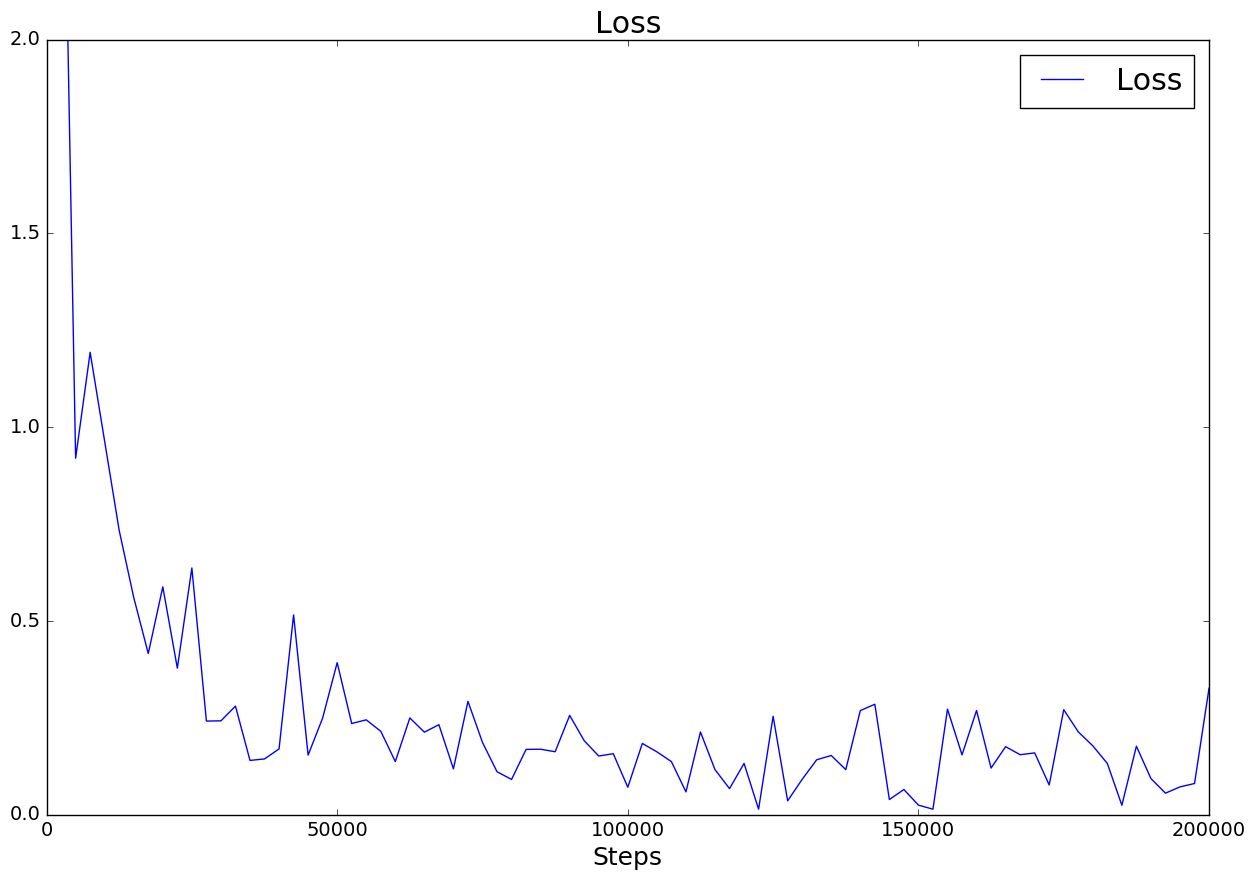

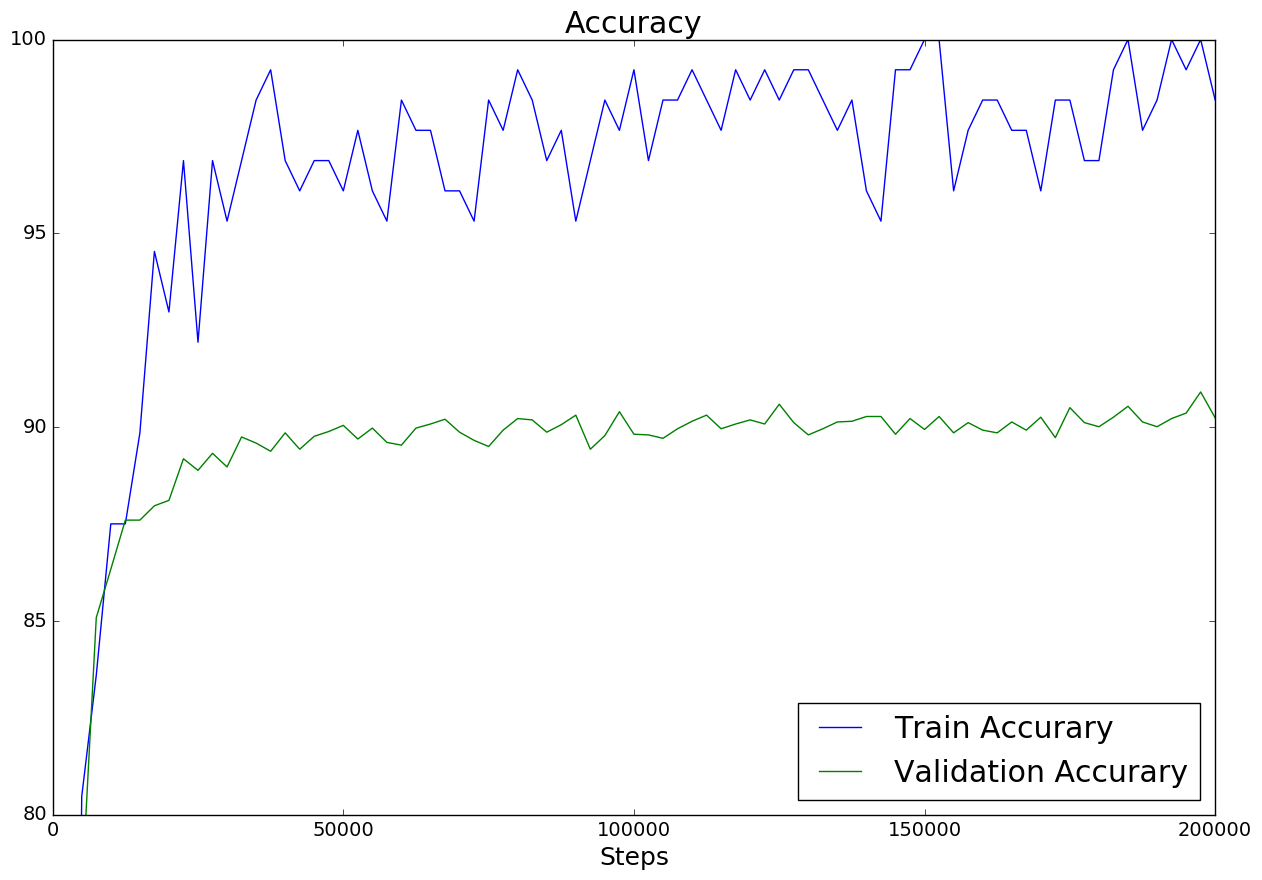

In [23]:
plot_results(acc_train,acc_valid,losses)


# Add a second fully connected layer, local response normalization before relu, two dropout layers in conv ¶

Conv ->Conv ->MaxPool-->conv->conv ->maxpool->conv->fully connected1 -> fully connected2 ->logits


In [115]:
def deepCNN2(datasets,topology_params, learning_params,model_name,num_channels=1):
    """Construct Model"""
    print ("deep CNN five conv layers two fully connected layers, lrn before relu")
    image_size = 32
    num_labels = 11 # 0-9, + blank 
    
    conv_stride = 1
    pool_window_size = [1, 2, 2, 1]
    pool_stride = [1, 2, 2, 1]
    padconv = 'SAME'
    padpool = 'SAME'
    patch_size5=5
    patch_size3=3
    train_dataset = datasets['train_dataset']
    train_labels = datasets['train_labels']
    valid_dataset = datasets['valid_dataset']
    valid_labels = datasets['valid_labels']
    test_dataset = datasets['test_dataset']
    test_labels = datasets['test_labels']
    

    depth1 = topology_params['depth1']
    depth2 = topology_params['depth2']
    depth3 = topology_params['depth3']
    depth4 = topology_params['depth4']
    depth5 = topology_params['depth5']
    patch_size1=topology_params['patch_size1']
    patch_size2=topology_params['patch_size2']

 
    num_hidden1 = topology_params['num_hidden1']
    num_hidden2 = topology_params['num_hidden2']
        
    num_steps=learning_params['num_steps']
    batch_size=learning_params['batch_size']
    learning_rate=learning_params['learning_rate']
     
    shape = [batch_size, image_size, image_size, num_channels]

    graph = tf.Graph()
    losses=OrderedDict()
    acc_train=OrderedDict()
    acc_valid=OrderedDict()
  
    
    with  graph.as_default():
      #define weights and biases
      # Input data.
      tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size, image_size, num_channels))
      tf_train_labels = tf.placeholder(tf.int32, shape=(batch_size, 6))
      tf_valid_dataset =  tf.placeholder(tf.float32, shape=(batch_size, image_size, image_size, num_channels))
      tf_valid_labels = tf.placeholder(tf.int32, shape=(batch_size, 6))
      tf_test_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size, image_size, num_channels))
      tf_test_labels = tf.placeholder(tf.int32, shape=(batch_size, 6))

      # Convolution layers.
      # First convolution layer
      conv_1_weights = create_weight_conv("W1",shape=[patch_size1, patch_size1, num_channels, depth1])
      conv_1_biases = create_bias('B1',shape=[depth1])     
      conv_1_shape = get_conv_shape(tf_train_dataset.get_shape().as_list(),conv_1_weights.get_shape().as_list(),\
                                    padconv,conv_stride)    
    
      print("cv1",conv_1_shape)
  
      # Second convolution layer 
      conv_2_weights = create_weight_conv("W2",shape=[patch_size1, patch_size1, depth1, depth2])
      conv_2_biases = create_bias('B2',shape=[depth2])
      conv_2_shape = get_conv_shape(conv_1_shape, conv_2_weights.get_shape().as_list(),padconv,conv_stride)
      pool_2_shape = get_pool_shape(conv_2_shape,pool_stride)
    
      print("cv2",conv_2_shape)
      print("p2",pool_2_shape)
    
    
      # Third convolution layer
      conv_3_weights = create_weight_conv("W3",shape=[patch_size2, patch_size2, depth2, depth3])
      conv_3_biases = create_bias('B3',shape=[depth3])     
      conv_3_shape = get_conv_shape(pool_2_shape,conv_3_weights.get_shape().as_list(),\
                                    padconv,conv_stride)    
    
      print("cv3",conv_3_shape)
  
      # Fourth convolution layer 
      conv_4_weights = create_weight_conv("W4",shape=[patch_size2, patch_size2, depth3, depth4])
      conv_4_biases = create_bias('B4',shape=[depth4])
      conv_4_shape = get_conv_shape(conv_3_shape, conv_4_weights.get_shape().as_list(),padconv,conv_stride)
      pool_4_shape = get_pool_shape(conv_4_shape,pool_stride)
    
      print("cv4",conv_4_shape)
      print("p4",pool_4_shape)
    
     # Fifth convolution layer 
      conv_5_weights = create_weight_conv("W5",shape=[patch_size2, patch_size2, depth4, num_hidden1])
      conv_5_biases = create_bias('B5',shape=[num_hidden1])
      conv_5_shape = get_conv_shape(pool_4_shape, conv_5_weights.get_shape().as_list(),padconv,conv_stride)
      pool_5_shape = get_pool_shape(conv_5_shape,pool_stride)
      
      print("cv5",conv_5_shape)
      print("p5",pool_5_shape)
    
      #Frist fully connected layer
      final_shape=pool_5_shape
      final_flat = final_shape[1] * final_shape[2] * final_shape[3]
      print("ff",final_flat)
    
      #second fully connected layer
      weights_full1 = create_weight("FW1",(final_flat, num_hidden1))
      biases_full1 = create_bias("FB1",(num_hidden1,))
  

      weights_full2 = create_weight("FW2",(num_hidden1, num_hidden2))
      biases_full2 = create_bias("FB2",(num_hidden2,))
        
      # Hidden layer
      s0_w = create_weight("WHS0",(num_hidden2, num_labels))
      s1_w = create_weight("WHS1",(num_hidden2, num_labels))
      s2_w = create_weight("WHS2",(num_hidden2, num_labels))
      s3_w = create_weight("WHS3",(num_hidden2, num_labels))
      s4_w = create_weight("WHS4",(num_hidden2, num_labels))
      s0_b = create_bias("BHS0",(num_labels,))
      s1_b = create_bias("BHS1",(num_labels,))
      s2_b = create_bias("BHS2",(num_labels,))
      s3_b = create_bias("BHS3",(num_labels,))
      s4_b = create_bias("BHS4",(num_labels,))   
    

      # CNN model
      def model(data, keep_prob):
     #   print ("keep prob",keep_prob)
        conv1 = create_conv_layer('C1',data, conv_1_weights,padconv,conv_stride) + conv_1_biases
        lrn1 = tf.nn.local_response_normalization(conv1)
        lrn1=tf.nn.dropout(lrn1, keep_prob)
        
        conv2 = create_conv_layer('C2',tf.nn.relu(lrn1), conv_2_weights,padconv,conv_stride) + conv_2_biases
        lrn2 = tf.nn.local_response_normalization(conv2)
        pool2 = create_pool_layer('P2',tf.nn.relu(lrn2),pool_window_size,padpool,pool_stride)
        pool2=tf.nn.dropout(pool2, keep_prob)
        
        conv3 = create_conv_layer('C3',pool2, conv_3_weights,padconv,conv_stride) + conv_3_biases
        lrn3 = tf.nn.local_response_normalization(conv3)
        lrn3=tf.nn.dropout(lrn3, keep_prob)
        
        conv4 = create_conv_layer('C4',tf.nn.relu(lrn3), conv_4_weights,padconv,conv_stride) + conv_4_biases
        lrn4 = tf.nn.local_response_normalization(conv4)
        pool4 = create_pool_layer('P4',tf.nn.relu(lrn4),pool_window_size,padpool,pool_stride)
        pool4=tf.nn.dropout(pool4, keep_prob)
        
        conv5 = create_conv_layer('C5',pool4, conv_5_weights,padconv,conv_stride) + conv_5_biases
        lrn5 = tf.nn.local_response_normalization(conv5)
        pool5 = create_pool_layer('P5',tf.nn.relu(lrn5),pool_window_size,padpool,pool_stride)
        pool5=tf.nn.dropout(pool5, keep_prob)
        last=pool5
      
        shape = last.get_shape().as_list() 
     #   print (shape)
        reshape = tf.reshape(last, [shape[0], final_flat])
        # First fully connected layer
        full1 = tf.nn.relu(tf.matmul(reshape, weights_full1) + biases_full1)
        final1 = tf.nn.dropout(full1, keep_prob)
       
       # Second fully connected layer
        full2 = tf.nn.relu(tf.matmul(final1, weights_full2) + biases_full2)
        final2 = tf.nn.dropout(full2, keep_prob)
        
        #logits
        logits0 = tf.matmul(final2, s0_w) + s0_b  #lenght of house number
        logits1 = tf.matmul(final2, s1_w) + s1_b  #1. digit
        logits2 = tf.matmul(final2, s2_w) + s2_b  #2. digit
        logits3 = tf.matmul(final2, s3_w) + s3_b  #3. digit
        logits4 = tf.matmul(final2, s4_w) + s4_b  #4. digit
        return [logits0, logits1, logits2, logits3, logits4]

      # Training computation.
      [logits0, logits1, logits2, logits3, logits4] = model(tf_train_dataset, 0.5)
      # Define loss function.
     
      loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits0, tf_train_labels[:,0])) +\
    tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits1, tf_train_labels[:,1])) +\
    tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits2, tf_train_labels[:,2])) +\
    tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits3, tf_train_labels[:,3])) +\
    tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits4, tf_train_labels[:,4]))

      # Optimizer.
      global_step = tf.Variable(0)
      #learning rate with exponential decay.
      learning_rate = tf.train.exponential_decay(learning_rate, global_step, 20000, 0.95) 
 
      
      optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss)
    
      # Predictions for the training, validation, and test data.
      [logits0, logits1, logits2, logits3, logits4] = model(tf_train_dataset, 1.0)
      train_prediction = tf.pack([tf.nn.softmax(logits0),\
                                 tf.nn.softmax(logits1),\
                                 tf.nn.softmax(logits2),\
                                 tf.nn.softmax(logits3),\
                                 tf.nn.softmax(logits4)])
    
      [logits0, logits1, logits2, logits3, logits4] = model(tf_valid_dataset, 1.0)
      valid_prediction = tf.pack([tf.nn.softmax(logits0),\
                                 tf.nn.softmax(logits1),\
                                 tf.nn.softmax(logits2),\
                                 tf.nn.softmax(logits3),\
                                 tf.nn.softmax(logits4)])   
    
      [logits0, logits1, logits2, logits3, logits4] = model(tf_test_dataset, 1.0)   
      test_prediction = tf.pack([tf.nn.softmax(logits0),\
                                 tf.nn.softmax(logits1),\
                                 tf.nn.softmax(logits2),\
                                 tf.nn.softmax(logits3),\
                                 tf.nn.softmax(logits4)])   

      saver = tf.train.Saver()



    with tf.Session(graph=graph) as session:
      tf.initialize_all_variables().run()  

      #"to be used after first iteration"
      #saver.restore(session, model_name)
      #print("Model restored.") 

      print('Initialized')
      for step in range(num_steps):
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
        batch_labels = train_labels[offset:(offset + batch_size),:]
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run(
          [optimizer, loss, train_prediction], feed_dict=feed_dict)

       
        if (step % 2500 == 0): 
          
            trainacc= accuracy(np.argmax(predictions, 2).T, batch_labels[:,0:5])
            acc_train[step]=trainacc   
            val_preds_total = np.ndarray((valid_labels.shape[0],valid_labels.shape[1]-1))
            for k in range(int(np.floor(valid_labels.shape[0] / batch_size))):
                batch_start_val = batch_size * k
                batch_end_val = batch_start_val + batch_size
                batch_D_val = valid_dataset[batch_start_val:batch_end_val,:,:,:]
                batch_L_val = valid_labels[batch_start_val:batch_end_val,:] 
                feed_dict = {tf_valid_dataset: batch_D_val, tf_valid_labels: batch_L_val}
                val_preds_total[batch_start_val:batch_end_val,:] = np.argmax(session.run(valid_prediction, feed_dict), 2).T
           
            val_preds_eval = val_preds_total   
          #  pred_val=valid_prediction.eval()
         #   valacc=accuracy(np.argmax(pred_val, 2).T, valid_labels[:,0:5])
            valacc=accuracy(val_preds_eval,valid_labels[:,0:5])
           
            acc_valid[step]=valacc
            
            valaccChar=accuracyCharLevel(val_preds_eval, valid_labels[:,0:5])
            losses[step]=l
            print('Minibatch loss at step %d: %f' % (step, l))
            print('Minibatch accuracy: %.2f%%' % trainacc)
            print('Validation accuracy: %.2f%%' % valacc)
            print('Validation accuracy character level: %.2f%%' % valaccChar)  
           
            
   
      test_labels_shape=test_labels.shape  
      test_preds_total = np.ndarray((test_labels.shape[0],test_labels.shape[1]-1))
      for j in range(int(np.floor(test_labels.shape[0] / batch_size))):
            batch_start_test = batch_size * j
            batch_end_test = batch_start_test + batch_size
            batch_D_test = test_dataset[batch_start_test:batch_end_test,:,:,:]
            batch_L_test = test_labels[batch_start_test:batch_end_test,:]                
            feed_dict = {tf_test_dataset: batch_D_test, tf_test_labels: batch_L_test}
            test_preds_total[batch_start_test:batch_end_test,:] = np.argmax(session.run(test_prediction, feed_dict), 2).T
      
      test_preds_eval = test_preds_total     
      testacc=accuracy(test_preds_total, test_labels[:,0:5],show_details=True,n=100)
      testaccChar=accuracyCharLevel(test_preds_total, test_labels[:,0:5])
      print('====> Test accuracy character level: %.2f%%' % testaccChar)  
  
      print('====> Test accuracy: %.2f%%' % testacc)
      save_path = saver.save(session, model_name)
      print("Model saved in file: %s" % save_path)
      return  acc_train,acc_valid,losses

In [117]:


datasets={}
topology_params={}
learning_params={}
learning_params={}


datasets['train_dataset']=train_dataset
datasets['train_labels']=train_labels
datasets['valid_dataset']=valid_dataset
datasets['valid_labels']=valid_labels
datasets['test_dataset']=test_dataset
datasets['test_labels']=test_labels


model_name="CNN_multi_deep_ful2_32x32.ckpt"


topology_params['patch_size1']=5
topology_params['patch_size2']=5
topology_params['depth1']=16*2
topology_params['depth2']=32*2
topology_params['depth3']=64*2
topology_params['depth4']=64*2
topology_params['depth5']=64*2

topology_params['num_hidden1']=64*6
topology_params['num_hidden2']=64*6

learning_params['num_steps']=300001
learning_params['batch_size']=128
learning_params['learning_rate']=1.0E-4
#two dropout layer
#adam optimizer with decay 
#learning_rate = tf.train.exponential_decay(learning_rate, global_step, 20000, 0.95) 
#optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss)
#====> Test accuracy character level: 98.08%
#====> Test accuracy: 94.28% !!!
# medium overfitting train acc ~97%, val acc ~92%
# Model saved in file: CNN_multi_deep_ful2_32x32.ckpt
# model renamed CNN_multi_deep_ful2_32x32_94_28.ckpt

#increase network capacity

topology_params['patch_size1']=5
topology_params['patch_size2']=5
topology_params['depth1']=16*2
topology_params['depth2']=32*2
topology_params['depth3']=64*2
topology_params['depth4']=64*3
topology_params['depth5']=64*3

topology_params['num_hidden1']=64*12
topology_params['num_hidden2']=64*12

learning_params['num_steps']=300001
learning_params['batch_size']=128
learning_params['learning_rate']=1.0E-4

#====> Test accuracy character level: 98.03%
#====> Test accuracy: 94.09%


topology_params['patch_size1']=5
topology_params['patch_size2']=5
topology_params['depth1']=16*2
topology_params['depth2']=32*2
topology_params['depth3']=64*2
topology_params['depth4']=64*2
topology_params['depth5']=64*2

topology_params['num_hidden1']=64*16*3
topology_params['num_hidden2']=64*16

learning_params['num_steps']=200001
learning_params['batch_size']=128
learning_params['learning_rate']=1.0E-4
#====> Test accuracy character level: 98.03%
#====> Test accuracy: 93.92%
#large overfitting  

#adding dropout layer to all conv layer
topology_params['patch_size1']=5
topology_params['patch_size2']=5
topology_params['depth1']=16*2
topology_params['depth2']=32*2
topology_params['depth3']=64*2
topology_params['depth4']=64*2
topology_params['depth5']=64*2

topology_params['num_hidden1']=64*8
topology_params['num_hidden2']=64*8

learning_params['num_steps']=300001
learning_params['batch_size']=128
learning_params['learning_rate']=1.0E-4
#====> Test accuracy character level: 98.09%
#====> Test accuracy: 94.28%
# train acc ~95 - 96%, val acc ~92%!!!


#dropout 0.5
topology_params['patch_size1']=5
topology_params['patch_size2']=5
topology_params['depth1']=16*2
topology_params['depth2']=32*4
topology_params['depth3']=64*4
topology_params['depth4']=64*4
topology_params['depth5']=64*4

topology_params['num_hidden1']=64*12
topology_params['num_hidden2']=64*12

learning_params['num_steps']=200001 
learning_params['batch_size']=128
learning_params['learning_rate']=1.0E-4

#dropout 0.5
# no learning decay
#====> Test accuracy character level: 98.23%
#====> Test accuracy: 94.71%

#dropout 0.6
#====> Test accuracy character level: 98.22%
#====> Test accuracy: 94.84%
#larger overfitting
#train acc ~98% val acc~92.5%
#dropout 0.45
#====> Test accuracy character level: 98.07%
#====> Test accuracy: 94.42%

#dropout 0.7
#====> Test accuracy character level: 98.21%
#====> Test accuracy: 94.62%

#dropout 0.55
#====> Test accuracy character level: 98.15%
#====> Test accuracy: 94.71%

topology_params['patch_size1']=5
topology_params['patch_size2']=5
topology_params['depth1']=16*2
topology_params['depth2']=32*4
topology_params['depth3']=64*4
topology_params['depth4']=64*4
topology_params['depth5']=64*4

topology_params['num_hidden1']=64*32
topology_params['num_hidden2']=64*32

learning_params['num_steps']=200001 
learning_params['batch_size']=128
learning_params['learning_rate']=1.0E-4

#====> Test accuracy character level: 98.08%
#====> Test accuracy: 94.26%
#large overfitting:  train acc ~99%, validation acc ~92%
#dropout 0.5
#adan with decay
topology_params['patch_size1']=5
topology_params['patch_size2']=5
topology_params['depth1']=16*2
topology_params['depth2']=32*4
topology_params['depth3']=64*4
topology_params['depth4']=64*4
topology_params['depth5']=64*4

topology_params['num_hidden1']=64*12
topology_params['num_hidden2']=64*12

learning_params['num_steps']=500001 
learning_params['batch_size']=128
learning_params['learning_rate']=1.0E-4
#====> Test accuracy character level: 98.41%
#====> Test accuracy: 95.46%
#model manually renamed to CNN_multi_deep_ful2_32x32_95_46.ckpt
acc_train,acc_valid,losses=deepCNN2(datasets,topology_params, learning_params,model_name)

deep CNN five conv layers two fully connected layers, lrn before relu
cv1 (128, 32, 32, 32)
cv2 (128, 32, 32, 128)
p2 (128, 16, 16, 128)
cv3 (128, 16, 16, 256)
cv4 (128, 16, 16, 256)
p4 (128, 8, 8, 256)
cv5 (128, 8, 8, 768)
p5 (128, 4, 4, 768)
ff 12288
Instructions for updating:
Use `tf.global_variables_initializer` instead.
Initialized
Minibatch loss at step 0: 35.747292
Minibatch accuracy: 0.00%
Validation accuracy: 0.04%
Validation accuracy character level: 29.35%
Minibatch loss at step 2500: 8.217712
Minibatch accuracy: 0.00%
Validation accuracy: 0.00%
Validation accuracy character level: 42.50%
Minibatch loss at step 5000: 7.953300
Minibatch accuracy: 0.00%
Validation accuracy: 0.00%
Validation accuracy character level: 42.50%
Minibatch loss at step 7500: 8.035036
Minibatch accuracy: 0.00%
Validation accuracy: 0.00%
Validation accuracy character level: 42.50%
Minibatch loss at step 10000: 7.914492
Minibatch accuracy: 0.00%
Validation accuracy: 0.00%
Validation accuracy character l

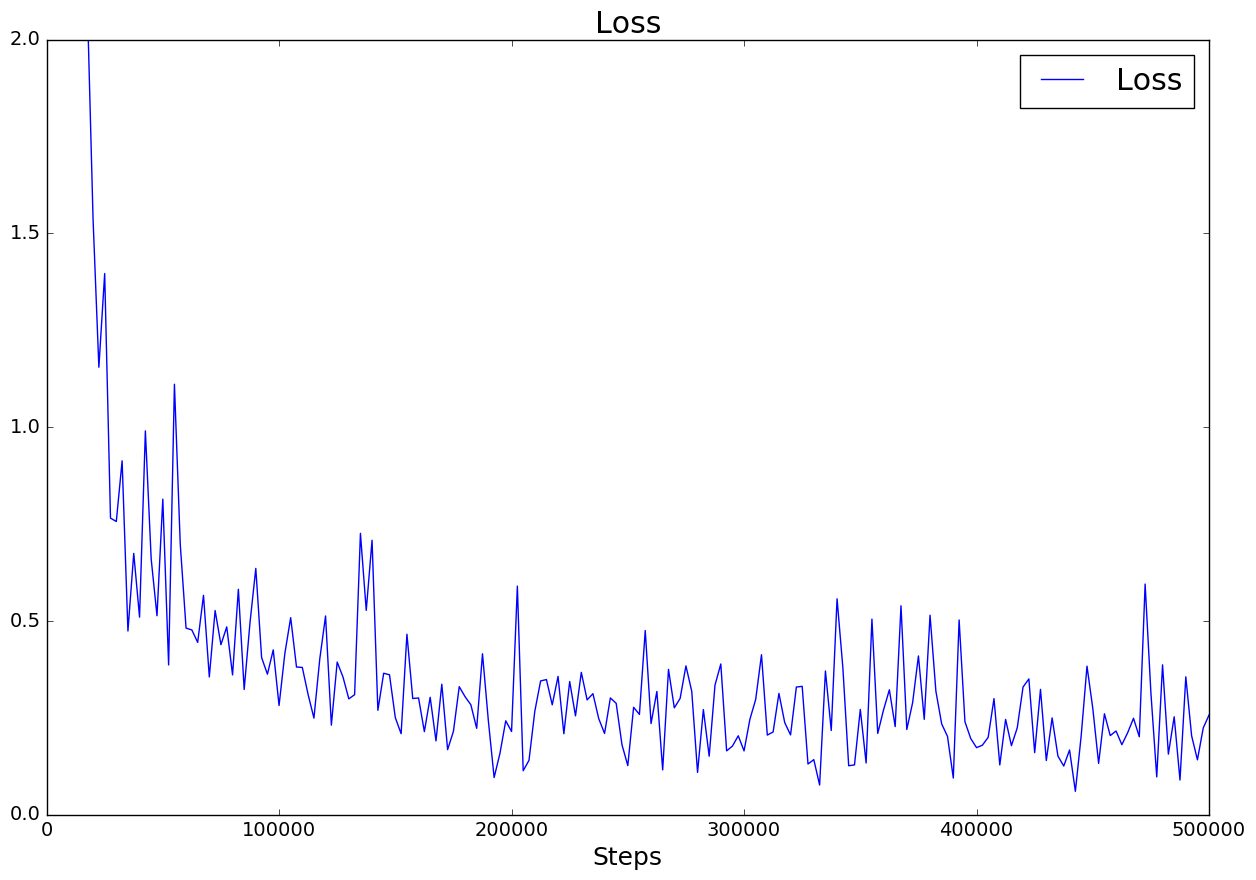

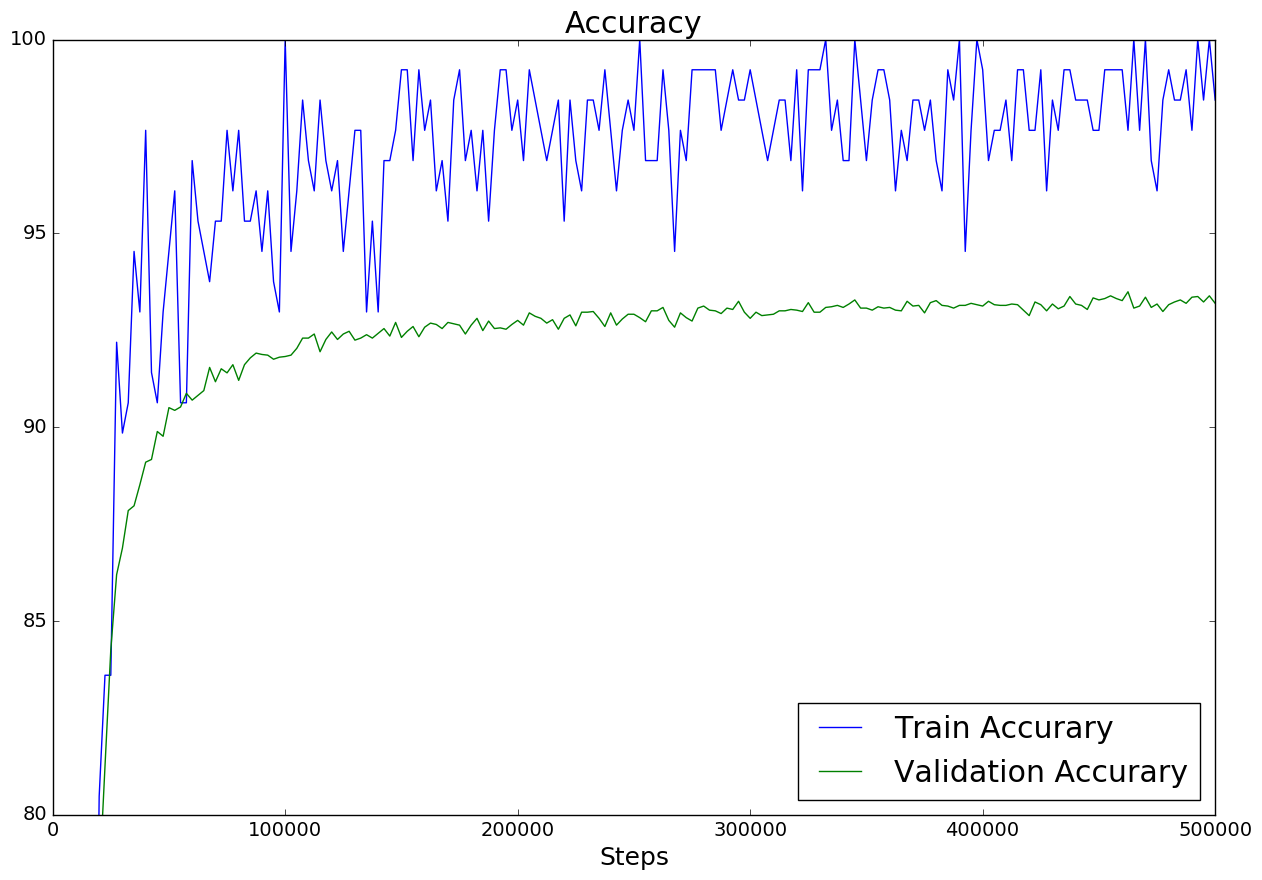

In [118]:
plot_results(acc_train,acc_valid,losses)

In [ ]:
plot_results(acc_train,acc_valid,losses)

In [ ]:
# Trying elu, no lrn

In [267]:
def deepCNN2(datasets,topology_params, learning_params,model_name,num_channels=1):
    """Construct Model"""
    print ("deep CNN five conv layers two fully connected layers,elu instead of relu")
    image_size = 32
    num_labels = 11 # 0-9, + blank 
    
    conv_stride = 1
    pool_window_size = [1, 2, 2, 1]
    pool_stride = [1, 2, 2, 1]
    padconv = 'SAME'
    padpool = 'SAME'
    patch_size5=5
    patch_size3=3
    train_dataset = datasets['train_dataset']
    train_labels = datasets['train_labels']
    valid_dataset = datasets['valid_dataset']
    valid_labels = datasets['valid_labels']
    test_dataset = datasets['test_dataset']
    test_labels = datasets['test_labels']
    

    depth1 = topology_params['depth1']
    depth2 = topology_params['depth2']
    depth3 = topology_params['depth3']
    depth4 = topology_params['depth4']
    depth5 = topology_params['depth5']
    patch_size1=topology_params['patch_size1']
    patch_size2=topology_params['patch_size2']

 
    num_hidden1 = topology_params['num_hidden1']
    num_hidden2 = topology_params['num_hidden2']
        
    num_steps=learning_params['num_steps']
    batch_size=learning_params['batch_size']
    learning_rate=learning_params['learning_rate']
     
    shape = [batch_size, image_size, image_size, num_channels]

    graph = tf.Graph()
    losses=OrderedDict()
    acc_train=OrderedDict()
    acc_valid=OrderedDict()
  
    
    with  graph.as_default():
      #define weights and biases
      # Input data.
      tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size, image_size, num_channels))
      tf_train_labels = tf.placeholder(tf.int32, shape=(batch_size, 6))
      tf_valid_dataset =  tf.placeholder(tf.float32, shape=(batch_size, image_size, image_size, num_channels))
      tf_valid_labels = tf.placeholder(tf.int32, shape=(batch_size, 6))
      tf_test_dataset = tf.placeholder(tf.float32, shape=(batch_size, image_size, image_size, num_channels))
      tf_test_labels = tf.placeholder(tf.int32, shape=(batch_size, 6))

      # Convolution layers.
      # First convolution layer
      conv_1_weights = create_weight_conv("W1",shape=[patch_size1, patch_size1, num_channels, depth1])
      conv_1_biases = create_bias('B1',shape=[depth1])     
      conv_1_shape = get_conv_shape(tf_train_dataset.get_shape().as_list(),conv_1_weights.get_shape().as_list(),\
                                    padconv,conv_stride)    
    
      print("cv1",conv_1_shape)
  
      # Second convolution layer 
      conv_2_weights = create_weight_conv("W2",shape=[patch_size1, patch_size1, depth1, depth2])
      conv_2_biases = create_bias('B2',shape=[depth2])
      conv_2_shape = get_conv_shape(conv_1_shape, conv_2_weights.get_shape().as_list(),padconv,conv_stride)
      pool_2_shape = get_pool_shape(conv_2_shape,pool_stride)
    
      print("cv2",conv_2_shape)
      print("p2",pool_2_shape)
    
    
      # Third convolution layer
      conv_3_weights = create_weight_conv("W3",shape=[patch_size2, patch_size2, depth2, depth3])
      conv_3_biases = create_bias('B3',shape=[depth3])     
      conv_3_shape = get_conv_shape(pool_2_shape,conv_3_weights.get_shape().as_list(),\
                                    padconv,conv_stride)    
    
      print("cv3",conv_3_shape)
  
      # Fourth convolution layer 
      conv_4_weights = create_weight_conv("W4",shape=[patch_size2, patch_size2, depth3, depth4])
      conv_4_biases = create_bias('B4',shape=[depth4])
      conv_4_shape = get_conv_shape(conv_3_shape, conv_4_weights.get_shape().as_list(),padconv,conv_stride)
      pool_4_shape = get_pool_shape(conv_4_shape,pool_stride)
    
      print("cv4",conv_4_shape)
      print("p4",pool_4_shape)
    
     # Fifth convolution layer 
      conv_5_weights = create_weight_conv("W5",shape=[patch_size2, patch_size2, depth4, num_hidden1])
      conv_5_biases = create_bias('B5',shape=[num_hidden1])
      conv_5_shape = get_conv_shape(pool_4_shape, conv_5_weights.get_shape().as_list(),padconv,conv_stride)
      pool_5_shape = get_pool_shape(conv_5_shape,pool_stride)
      
      print("cv5",conv_5_shape)
      print("p5",pool_5_shape)
    
      #Frist fully connected layer
      final_shape=pool_5_shape
      final_flat = final_shape[1] * final_shape[2] * final_shape[3]
      print("ff",final_flat)
    
      #second fully connected layer
      weights_full1 = create_weight("FW1",(final_flat, num_hidden1))
      biases_full1 = create_bias("FB1",(num_hidden1,))
  

      weights_full2 = create_weight("FW2",(num_hidden1, num_hidden2))
      biases_full2 = create_bias("FB2",(num_hidden2,))
        
      # Hidden layer
      s0_w = create_weight("WHS0",(num_hidden2, num_labels))
      s1_w = create_weight("WHS1",(num_hidden2, num_labels))
      s2_w = create_weight("WHS2",(num_hidden2, num_labels))
      s3_w = create_weight("WHS3",(num_hidden2, num_labels))
      s4_w = create_weight("WHS4",(num_hidden2, num_labels))
      s0_b = create_bias("BHS0",(num_labels,))
      s1_b = create_bias("BHS1",(num_labels,))
      s2_b = create_bias("BHS2",(num_labels,))
      s3_b = create_bias("BHS3",(num_labels,))
      s4_b = create_bias("BHS4",(num_labels,))   
    

      # CNN model
      def model(data, keep_prob):
       
        conv1 = create_conv_layer('C1',data, conv_1_weights,padconv,conv_stride) + conv_1_biases
   
        lrn1=tf.nn.dropout(conv1, keep_prob)
        
        conv2 = create_conv_layer('C2',tf.nn.elu(lrn1), conv_2_weights,padconv,conv_stride) + conv_2_biases
   
        pool2 = create_pool_layer('P2',tf.nn.elu(conv2),pool_window_size,padpool,pool_stride)
        pool2=tf.nn.dropout(pool2, keep_prob)
        
        conv3 = create_conv_layer('C3',pool2, conv_3_weights,padconv,conv_stride) + conv_3_biases
    
        lrn3=tf.nn.dropout(conv3, keep_prob)
        
        conv4 = create_conv_layer('C4',tf.nn.elu(lrn3), conv_4_weights,padconv,conv_stride) + conv_4_biases
    
        pool4 = create_pool_layer('P4',tf.nn.elu(conv4),pool_window_size,padpool,pool_stride)
        pool4=tf.nn.dropout(pool4, keep_prob)
        
        conv5 = create_conv_layer('C5',pool4, conv_5_weights,padconv,conv_stride) + conv_5_biases
  
        pool5 = create_pool_layer('P5',tf.nn.elu(conv5),pool_window_size,padpool,pool_stride)
        pool5=tf.nn.dropout(pool5, keep_prob)
        last=pool5
      
        shape = last.get_shape().as_list() 
     #   print (shape)
        reshape = tf.reshape(last, [shape[0], final_flat])
        # First fully connected layer
        full1 = tf.nn.relu(tf.matmul(reshape, weights_full1) + biases_full1)
        final1 = tf.nn.dropout(full1, keep_prob)
       
       # Second fully connected layer
        full2 = tf.nn.relu(tf.matmul(final1, weights_full2) + biases_full2)
        final2 = tf.nn.dropout(full2, keep_prob)
        
        #logits
        logits0 = tf.matmul(final2, s0_w) + s0_b  #lenght of house number
        logits1 = tf.matmul(final2, s1_w) + s1_b  #1. digit
        logits2 = tf.matmul(final2, s2_w) + s2_b  #2. digit
        logits3 = tf.matmul(final2, s3_w) + s3_b  #3. digit
        logits4 = tf.matmul(final2, s4_w) + s4_b  #4. digit
        return [logits0, logits1, logits2, logits3, logits4]

      # Training computation.
      [logits0, logits1, logits2, logits3, logits4] = model(tf_train_dataset, 0.6)
      # Define loss function.
     
      loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits0, tf_train_labels[:,0])) +\
    tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits1, tf_train_labels[:,1])) +\
    tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits2, tf_train_labels[:,2])) +\
    tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits3, tf_train_labels[:,3])) +\
    tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits4, tf_train_labels[:,4]))

      # Optimizer.
      global_step = tf.Variable(0)
      #learning rate with exponential decay.
   #   learning_rate = tf.train.exponential_decay(learning_rate, global_step, 20000, 0.95) 
 
      
      optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss)
    
      # Predictions for the training, validation, and test data.
      [logits0, logits1, logits2, logits3, logits4] = model(tf_train_dataset, 1.0)
      train_prediction = tf.pack([tf.nn.softmax(logits0),\
                                 tf.nn.softmax(logits1),\
                                 tf.nn.softmax(logits2),\
                                 tf.nn.softmax(logits3),\
                                 tf.nn.softmax(logits4)])
    
      [logits0, logits1, logits2, logits3, logits4] = model(tf_valid_dataset, 1.0)
      valid_prediction = tf.pack([tf.nn.softmax(logits0),\
                                 tf.nn.softmax(logits1),\
                                 tf.nn.softmax(logits2),\
                                 tf.nn.softmax(logits3),\
                                 tf.nn.softmax(logits4)])   
    
      [logits0, logits1, logits2, logits3, logits4] = model(tf_test_dataset, 1.0)   
      test_prediction = tf.pack([tf.nn.softmax(logits0),\
                                 tf.nn.softmax(logits1),\
                                 tf.nn.softmax(logits2),\
                                 tf.nn.softmax(logits3),\
                                 tf.nn.softmax(logits4)])   
      saver = tf.train.Saver()



    with tf.Session(graph=graph) as session:
      tf.initialize_all_variables().run()  

      #"to be used after first iteration"
      #saver.restore(session, model_name)
      #print("Model restored.") 

      print('Initialized')
      for step in range(num_steps):
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
        batch_labels = train_labels[offset:(offset + batch_size),:]
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run(
          [optimizer, loss, train_prediction], feed_dict=feed_dict)

       
        if (step % 2500 == 0): 
          
            trainacc= accuracy(np.argmax(predictions, 2).T, batch_labels[:,0:5])
            trainaccChar=accuracyCharLevel(np.argmax(predictions, 2).T, batch_labels[:,0:5])
   
            acc_train[step]=trainacc   
            val_preds_total = np.ndarray((valid_labels.shape[0],valid_labels.shape[1]-1))
            for k in range(int(np.floor(valid_labels.shape[0] / batch_size))):
                batch_start_val = batch_size * k
                batch_end_val = batch_start_val + batch_size
                batch_D_val = valid_dataset[batch_start_val:batch_end_val,:,:,:]
                batch_L_val = valid_labels[batch_start_val:batch_end_val,:] 
                feed_dict = {tf_valid_dataset: batch_D_val, tf_valid_labels: batch_L_val}
                val_preds_total[batch_start_val:batch_end_val,:] = np.argmax(session.run(valid_prediction, feed_dict), 2).T
           
            val_preds_eval = val_preds_total   
          #  pred_val=valid_prediction.eval()
        
            valacc=accuracy(val_preds_eval,valid_labels[:,0:5])
           
            acc_valid[step]=valacc
            
            valaccChar=accuracyCharLevel(val_preds_eval, valid_labels[:,0:5])
            losses[step]=l
            print('Minibatch loss at step %d: %f' % (step, l))
            print('Minibatch accuracy: %.2f%%' % trainacc)
            print('Validation accuracy: %.2f%%' % valacc)
            print('Minibatch accuracy character lever: %.2f%%' % trainaccChar)
            print('Validation accuracy character level: %.2f%%' % valaccChar)  
           
            
   
      test_labels_shape=test_labels.shape  
      test_preds_total = np.ndarray((test_labels.shape[0],test_labels.shape[1]-1))
      for j in range(int(np.floor(test_labels.shape[0] / batch_size))):
            batch_start_test = batch_size * j
            batch_end_test = batch_start_test + batch_size
            batch_D_test = test_dataset[batch_start_test:batch_end_test,:,:,:]
            batch_L_test = test_labels[batch_start_test:batch_end_test,:]                
            feed_dict = {tf_test_dataset: batch_D_test, tf_test_labels: batch_L_test}
            test_preds_total[batch_start_test:batch_end_test,:] = np.argmax(session.run(test_prediction, feed_dict), 2).T
      
      test_preds_eval = test_preds_total     
      testacc=accuracy(test_preds_total, test_labels[:,0:5],show_details=True,n=100)
      testaccChar=accuracyCharLevel(test_preds_total, test_labels[:,0:5])
      print('====> Test accuracy character level: %.2f%%' % testaccChar)  
  
      print('====> Test accuracy: %.2f%%' % testacc)
      save_path = saver.save(session, model_name)
      print("Model saved in file: %s" % save_path)
      return  acc_train,acc_valid,losses

In [268]:


datasets={}
topology_params={}
learning_params={}
learning_params={}


datasets['train_dataset']=train_dataset
datasets['train_labels']=train_labels
datasets['valid_dataset']=valid_dataset
datasets['valid_labels']=valid_labels
datasets['test_dataset']=test_dataset
datasets['test_labels']=test_labels


model_name="CNN_multi_deep_ful2_32x32.ckpt"

#adam optim no decay
topology_params['patch_size1']=5
topology_params['patch_size2']=5
topology_params['depth1']=16*2
topology_params['depth2']=32*2
topology_params['depth3']=64*2
topology_params['depth4']=64*2
topology_params['depth5']=64*2

topology_params['num_hidden1']=64*6
topology_params['num_hidden2']=64*6

learning_params['num_steps']=300001
learning_params['batch_size']=128
learning_params['learning_rate']=1.0E-4
#two dropout laye, elu activitian
#====> Test accuracy character level: 97.77%
#====> Test accuracy: 93.50%
#lower offerfitting train acc ~ 95%, val acc ~92%

#increase network capacity
topology_params['patch_size1']=5
topology_params['patch_size2']=5
topology_params['depth1']=16*2
topology_params['depth2']=32*2
topology_params['depth3']=64*2
topology_params['depth4']=64*4
topology_params['depth5']=64*4

topology_params['num_hidden1']=64*12
topology_params['num_hidden2']=64*12

learning_params['num_steps']=300001
learning_params['batch_size']=128
learning_params['learning_rate']=1.0E-4
#====> Test accuracy character level: 98.00%
#====> Test accuracy: 94.19%
#lower offerfitting train acc ~ 96%, val acc ~92%

#increase network capacity
topology_params['patch_size1']=5
topology_params['patch_size2']=5
topology_params['depth1']=16*2
topology_params['depth2']=32*4
topology_params['depth3']=64*4
topology_params['depth4']=64*4
topology_params['depth5']=64*4

topology_params['num_hidden1']=64*12
topology_params['num_hidden2']=64*12

learning_params['num_steps']=300001
learning_params['batch_size']=128
learning_params['learning_rate']=1.0E-4

#====> Test accuracy character level: 98.18% !!
#====> Test accuracy: 94.68% !!
#train acc 95 - 98%, val acc 92 to 92.5%
#model name renamed to CNN_multi_deep_ful2_32x32_94_68.ckpt


#increase network capacity further
topology_params['patch_size1']=5
topology_params['patch_size2']=5
topology_params['depth1']=16*2
topology_params['depth2']=32*4
topology_params['depth3']=64*4
topology_params['depth4']=64*8
topology_params['depth5']=64*8

topology_params['num_hidden1']=64*12
topology_params['num_hidden2']=64*12

learning_params['num_steps']=300001
learning_params['batch_size']=128
learning_params['learning_rate']=1.0E-4
#====> Test accuracy character level: 98.06%
#====> Test accuracy: 94.18%
#try best again 
topology_params['patch_size1']=5
topology_params['patch_size2']=5
topology_params['depth1']=16*2
topology_params['depth2']=32*4
topology_params['depth3']=64*4
topology_params['depth4']=64*4
topology_params['depth5']=64*4

topology_params['num_hidden1']=64*12
topology_params['num_hidden2']=64*12

learning_params['num_steps']=100001 #only 100,000 steps
learning_params['batch_size']=128
learning_params['learning_rate']=1.0E-4
#====> Test accuracy character level: 97.91%
#====> Test accuracy: 93.77% ---> more steps helps - see above

#change dropout to 0.6
#====> Test accuracy character level: 98.12%
#====> Test accuracy: 94.25%
    
#change dropout to 0.7
#====> Test accuracy character level: 98.02%
#====> Test accuracy: 94.17%


#change dropout to 0.65
#====> Test accuracy character level: 98.10%
#====> Test accuracy: 94.34%
#now 200.000 steps
learning_params['num_steps']=200001    
#====> Test accuracy character level: 98.22%
#====> Test accuracy: 94.76%
#model name renamed to CNN_multi_deep_ful2_32x32_94_76.ckpt
learning_params['num_steps']=300001    
#====> Test accuracy character level: 98.20%
#====> Test accuracy: 94.64%

#change dropout to 0.6
#now 200.000 steps
learning_params['num_steps']=200001    
#====> Test accuracy character level: 98.14%
#====> Test accuracy: 94.49%
acc_train,acc_valid,losses=deepCNN2(datasets,topology_params, learning_params,model_name)

deep CNN five conv layers two fully connected layers,elu instead of relu
cv1 (128, 32, 32, 32)
cv2 (128, 32, 32, 128)
p2 (128, 16, 16, 128)
cv3 (128, 16, 16, 256)
cv4 (128, 16, 16, 256)
p4 (128, 8, 8, 256)
cv5 (128, 8, 8, 768)
p5 (128, 4, 4, 768)
ff 12288
Instructions for updating:
Use `tf.global_variables_initializer` instead.
Initialized
Minibatch loss at step 0: 78.571274
Minibatch accuracy: 0.00%
Validation accuracy: 0.00%
Minibatch accuracy character lever: 12.81%
Validation accuracy character level: 40.70%
Minibatch loss at step 2500: 5.508461
Minibatch accuracy: 6.25%
Validation accuracy: 4.87%
Minibatch accuracy character lever: 63.12%
Validation accuracy character level: 60.40%
Minibatch loss at step 5000: 2.492435
Minibatch accuracy: 60.94%
Validation accuracy: 64.13%
Minibatch accuracy character lever: 87.81%
Validation accuracy character level: 88.31%
Minibatch loss at step 7500: 1.902429
Minibatch accuracy: 77.34%
Validation accuracy: 75.30%
Minibatch accuracy character le